In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import boxcox
pd.options.display.max_rows = 50
pd.options.display.max_columns = 999
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_original_data():
    return pd.read_excel("Data/Data_MidTerm_Project_Real_State_Regression.xls" )

In [3]:
def clean_data(df):
    df=df.dropna()
    ## droping columns
    df=df.drop(columns=['id','view','lat','long','sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'])
    ## removing duplicates
    df=df.drop_duplicates()
    #date changed to dd/mm/year format
    df['date'] = df['date'].dt.strftime('%Y')
    #changing price values to currency format
    df['price'] = df['price'].apply(lambda x: "{:.2f}".format((x/1000)))
    df['price'] = df['price'].astype(float)
    return df

In [4]:
re_df=load_original_data()
re_df=clean_data(re_df)

In [5]:
re_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          21597 non-null  object 
 1   bedrooms      21597 non-null  int64  
 2   bathrooms     21597 non-null  float64
 3   sqft_living   21597 non-null  int64  
 4   sqft_lot      21597 non-null  int64  
 5   floors        21597 non-null  float64
 6   waterfront    21597 non-null  int64  
 7   condition     21597 non-null  int64  
 8   grade         21597 non-null  int64  
 9   yr_built      21597 non-null  int64  
 10  yr_renovated  21597 non-null  int64  
 11  zipcode       21597 non-null  int64  
 12  price         21597 non-null  float64
dtypes: float64(3), int64(9), object(1)
memory usage: 2.3+ MB


In [6]:
re_df.shape

(21597, 13)

### Plotting

Plot the distribution of price vs. number of bedrooms, price vs. number of bathrooms, price vs. condition, price vs. floors, price vs. grade, price vs. view, and price vs. waterfront.

State your observation for each one of those graphs. 
Do you see any trends in prices vs the rest of those variables individually? This can also be used for EDA to identify some data cleaning operations that you might need to perform further.

In [7]:
re_df[['bedrooms','bathrooms', 'floors','waterfront','condition','grade','yr_built','yr_renovated','zipcode']] = re_df[['bedrooms','bathrooms', 'floors','waterfront','condition','grade','yr_built','yr_renovated','zipcode']].astype(str)
# converting categorical columns

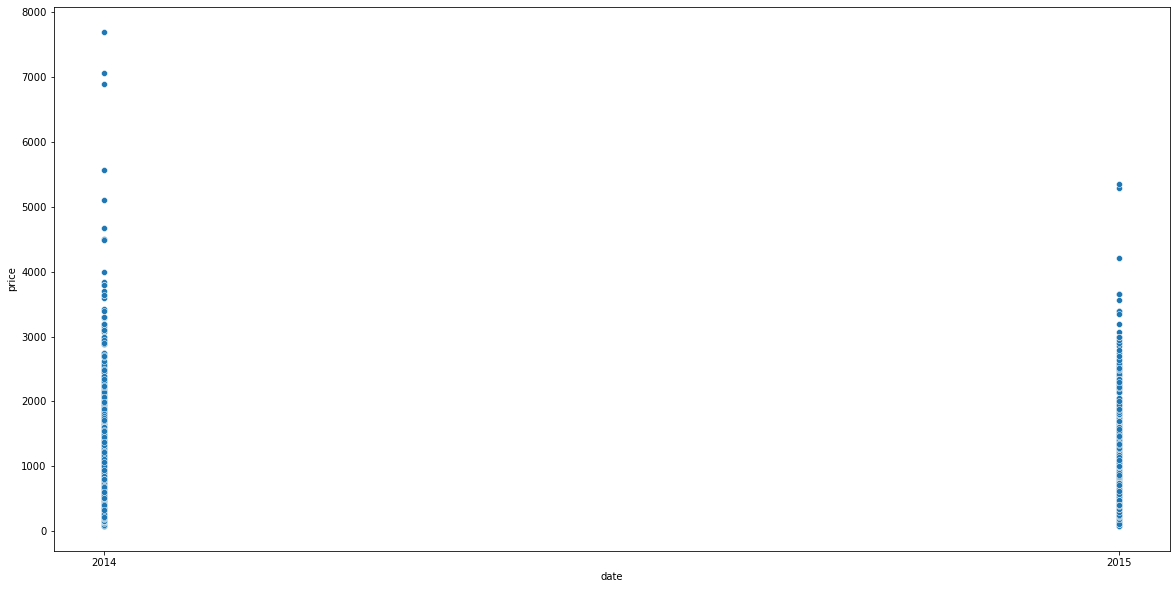

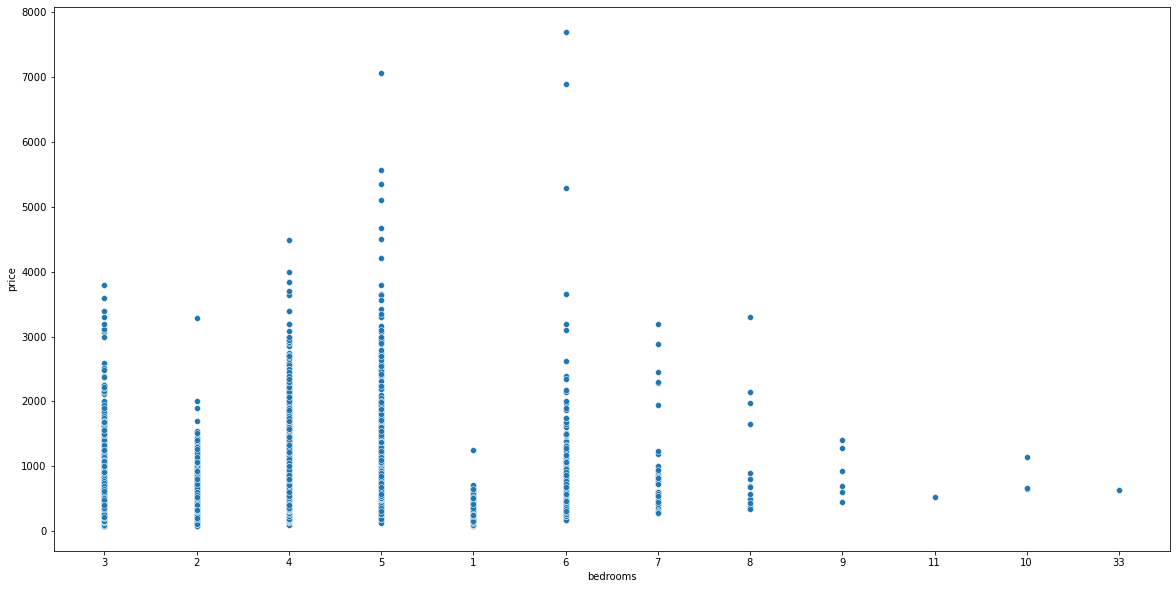

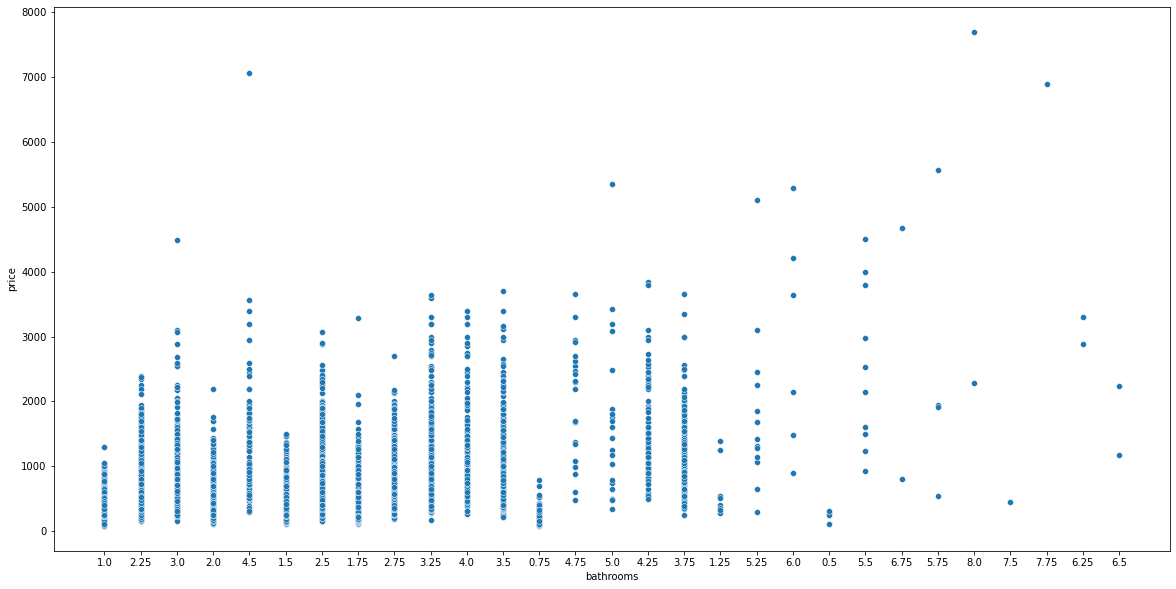

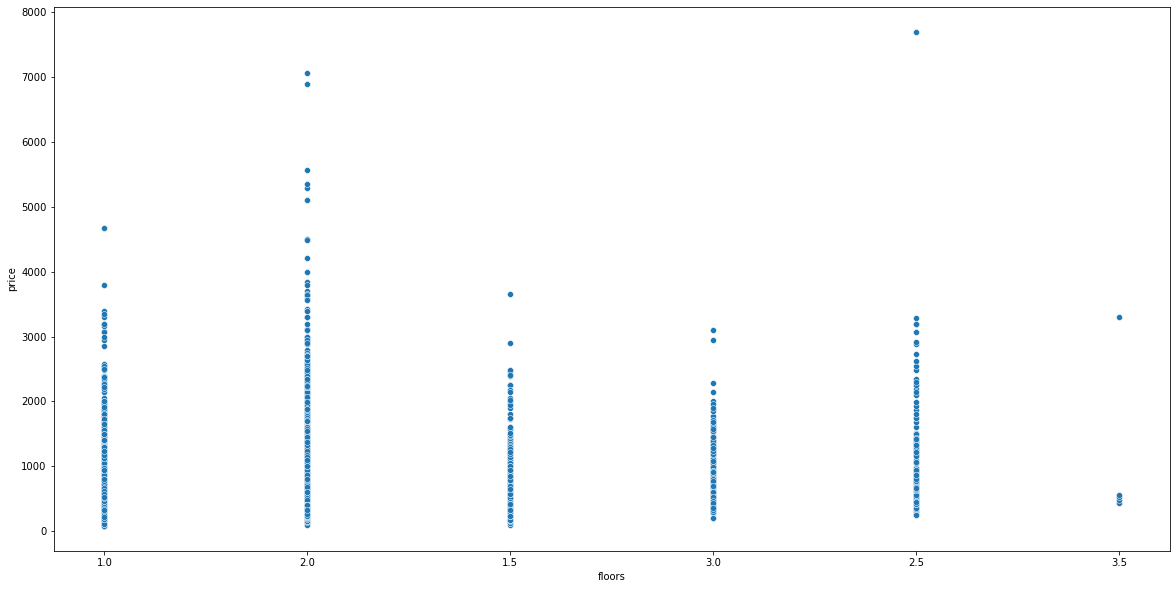

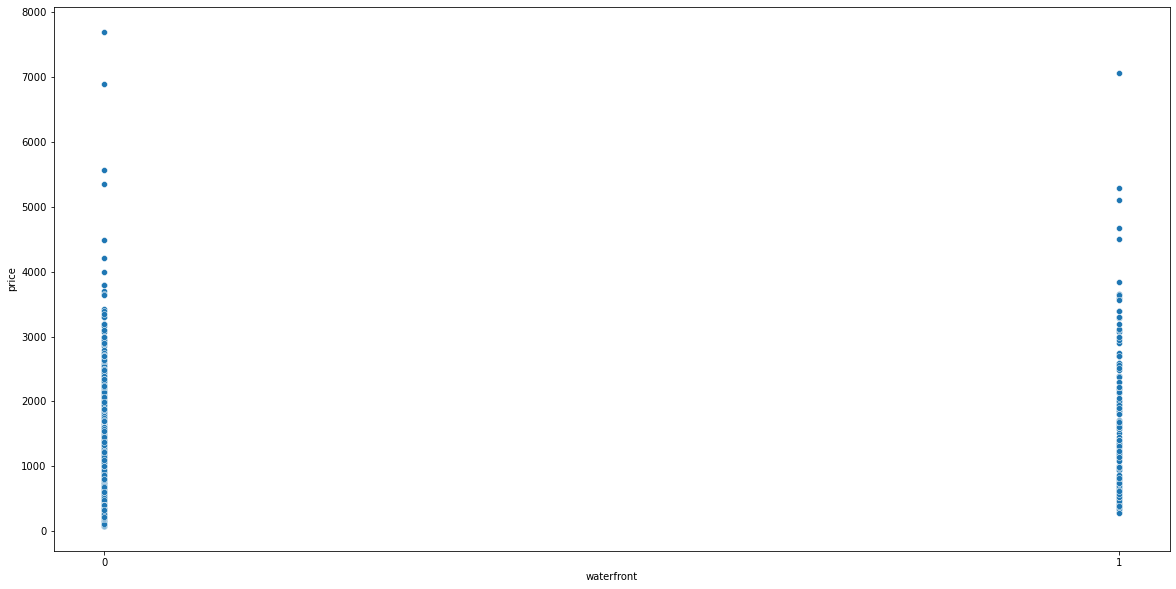

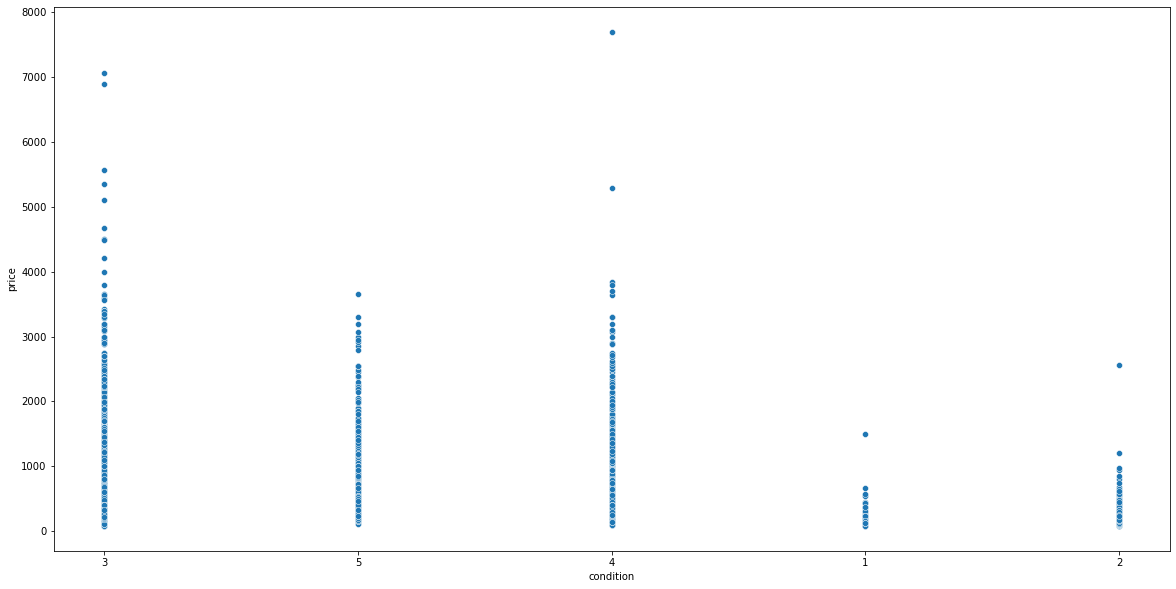

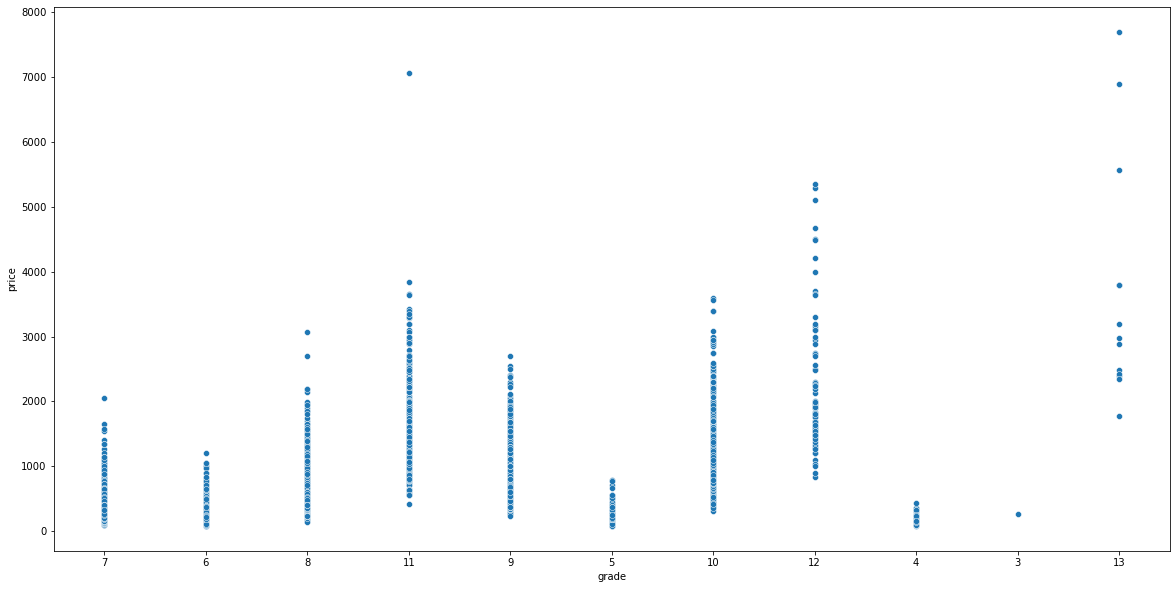

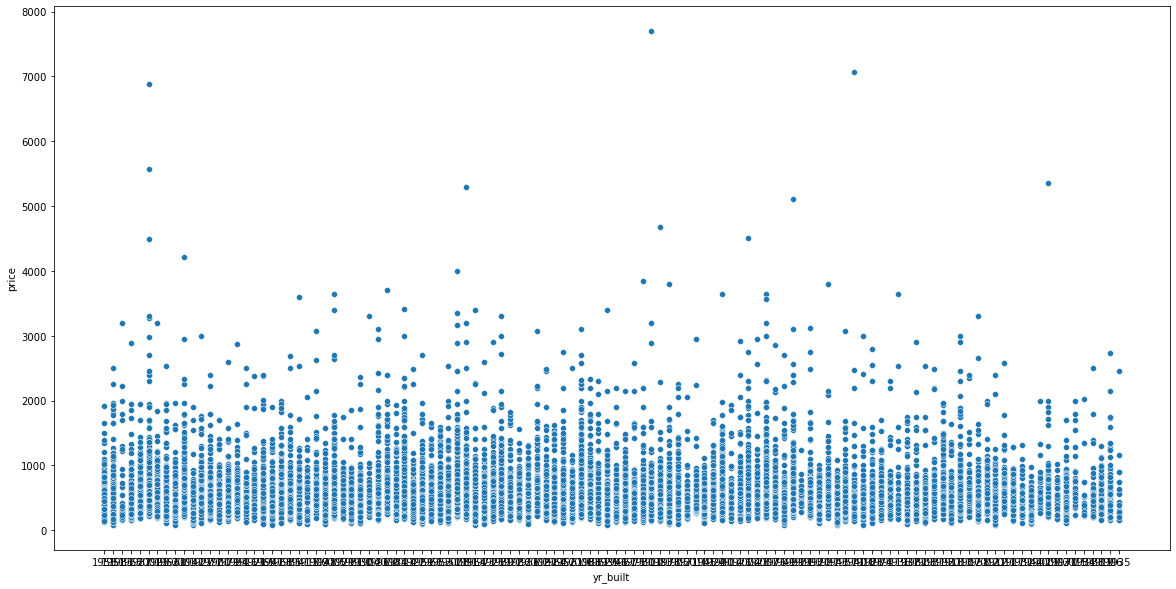

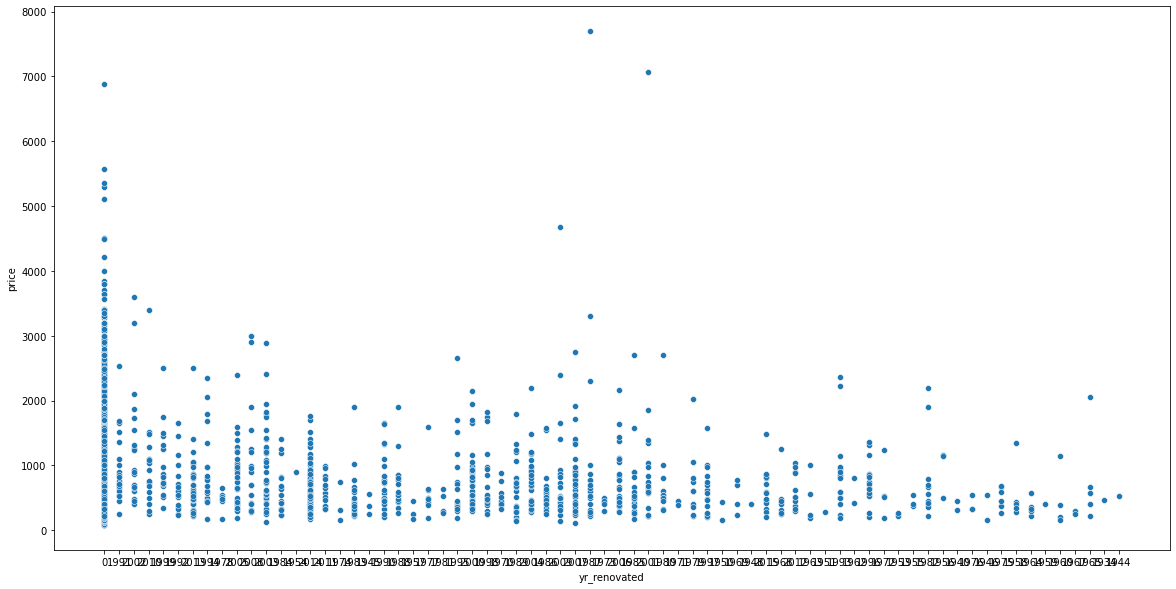

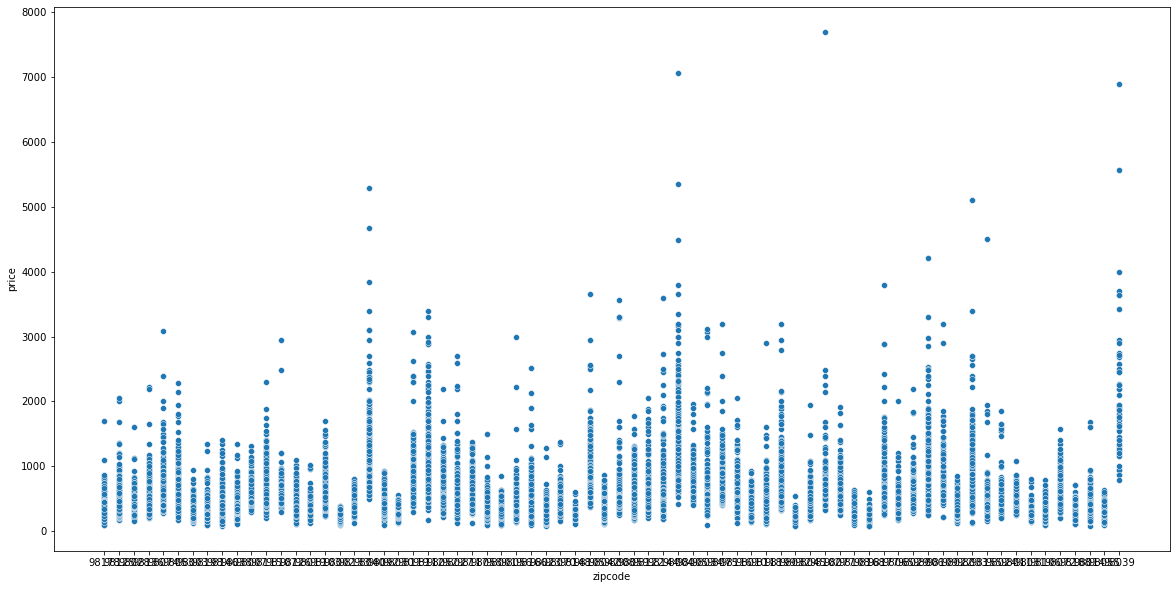

In [8]:
for c in re_df.select_dtypes(object):
    plt.figure(figsize=(20,10))
    sns.scatterplot(y='price',x=re_df[c],data=re_df)
    plt.show()

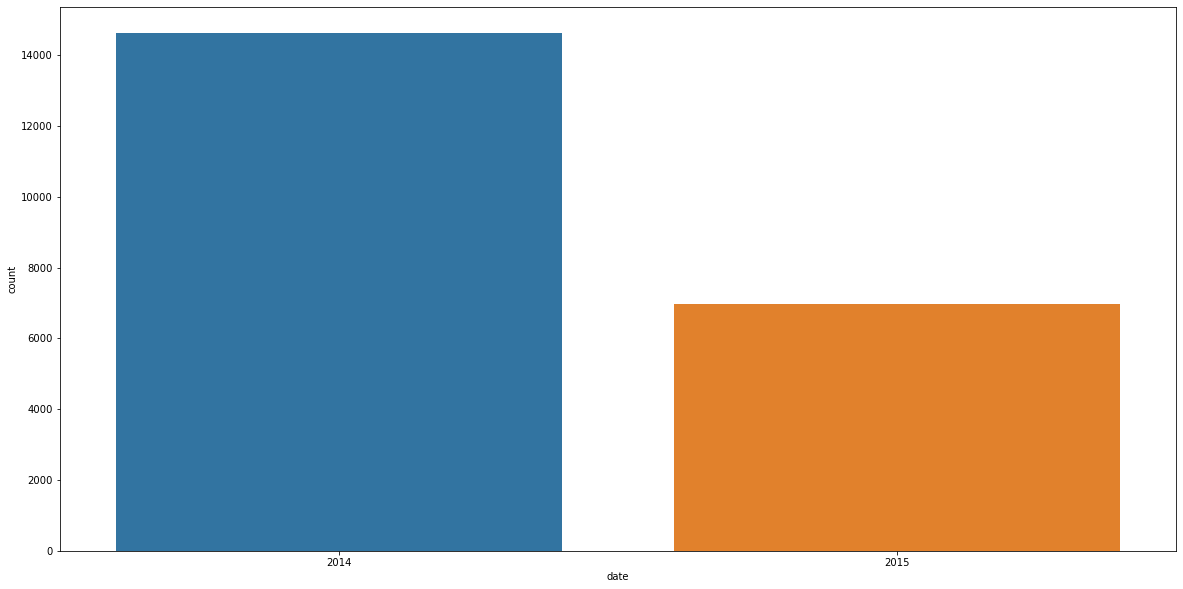

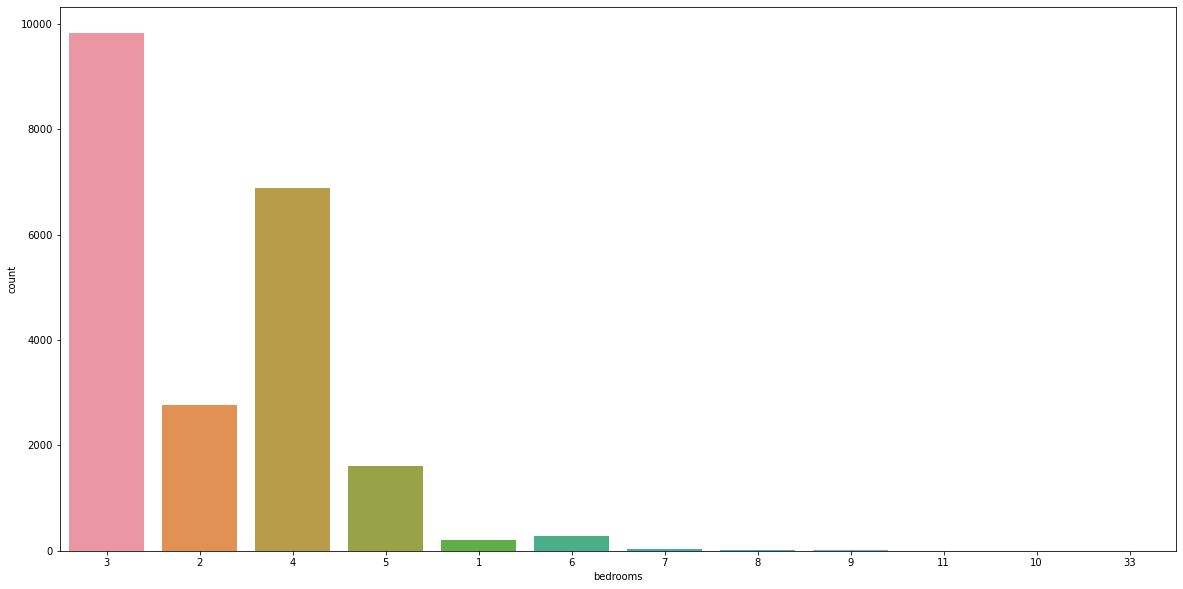

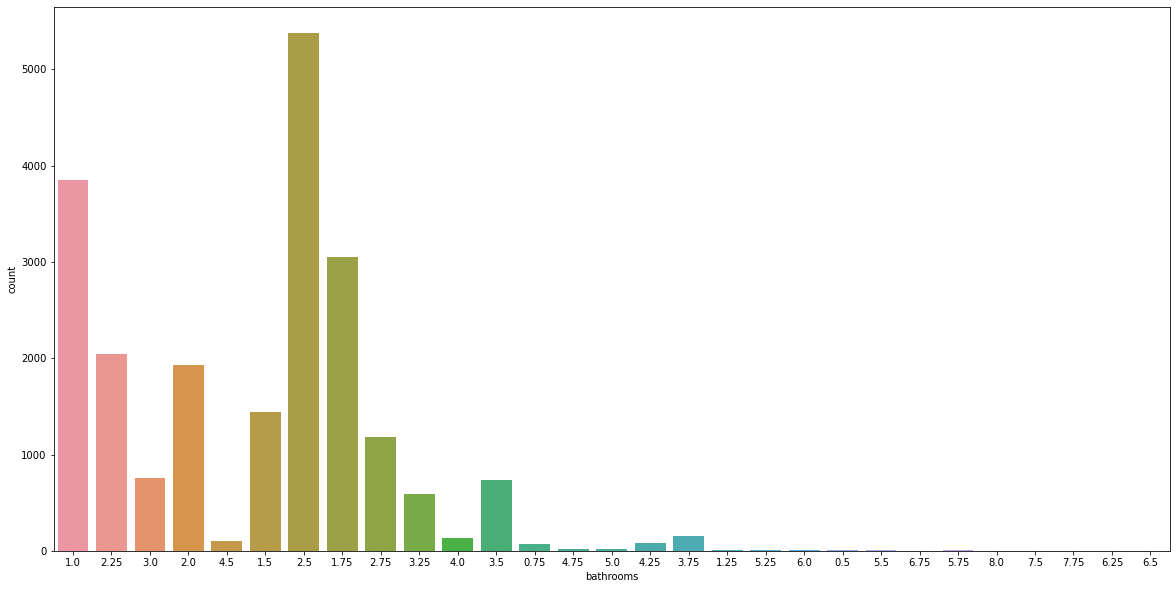

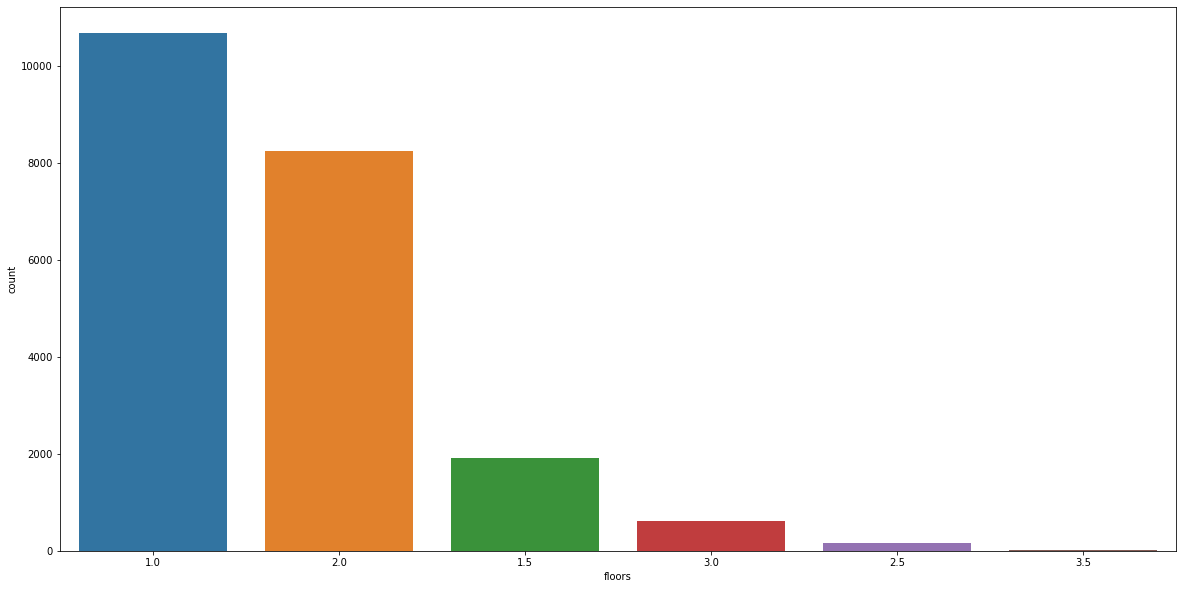

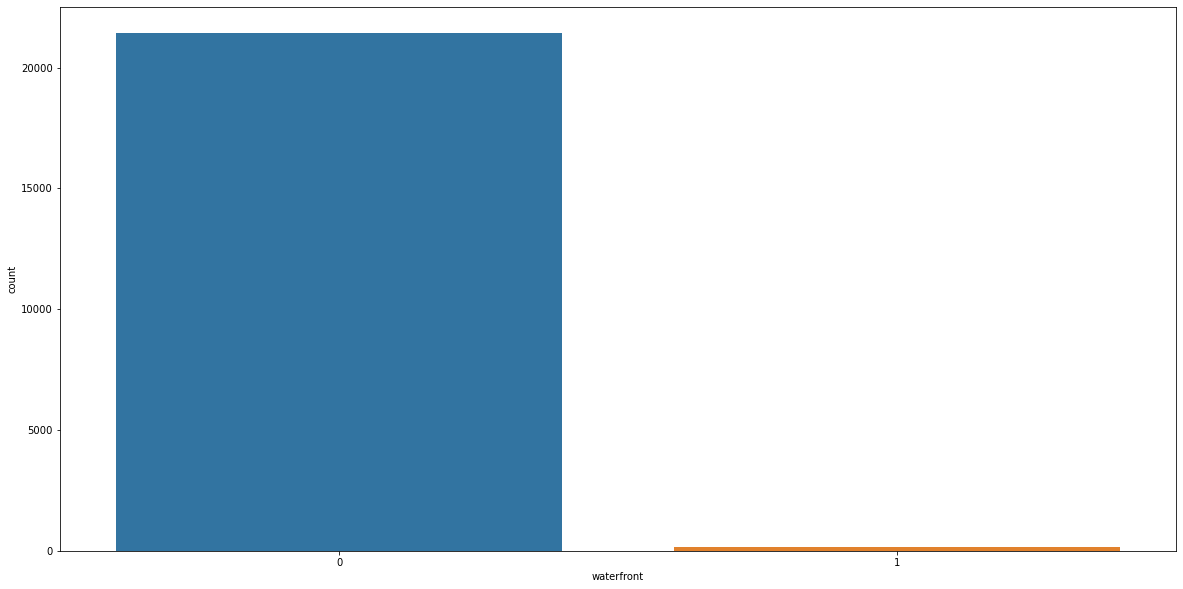

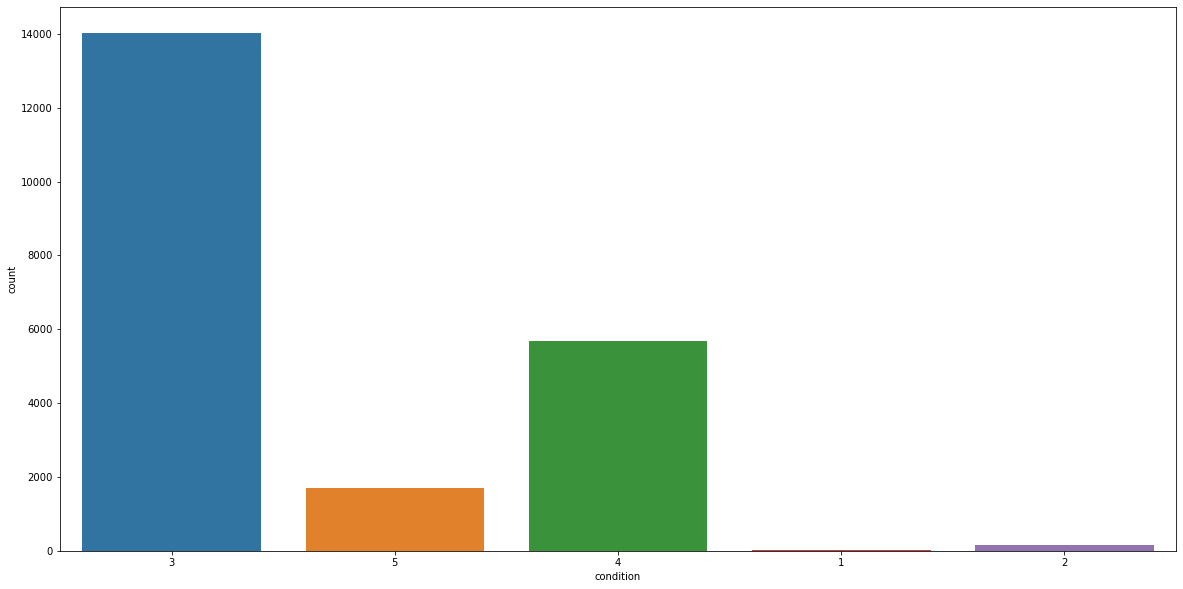

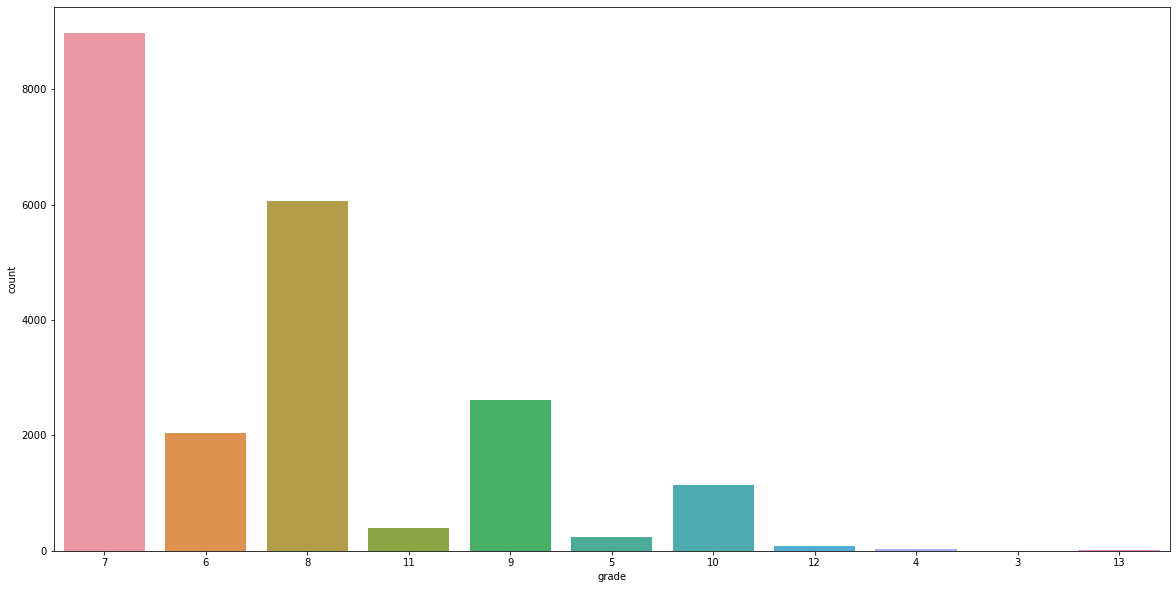

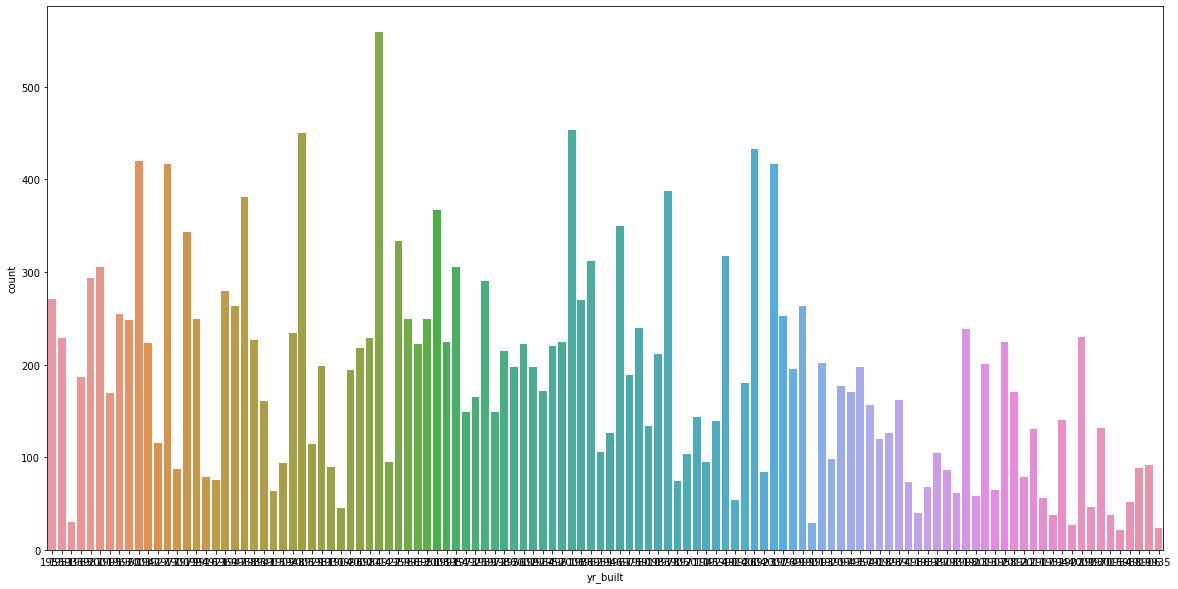

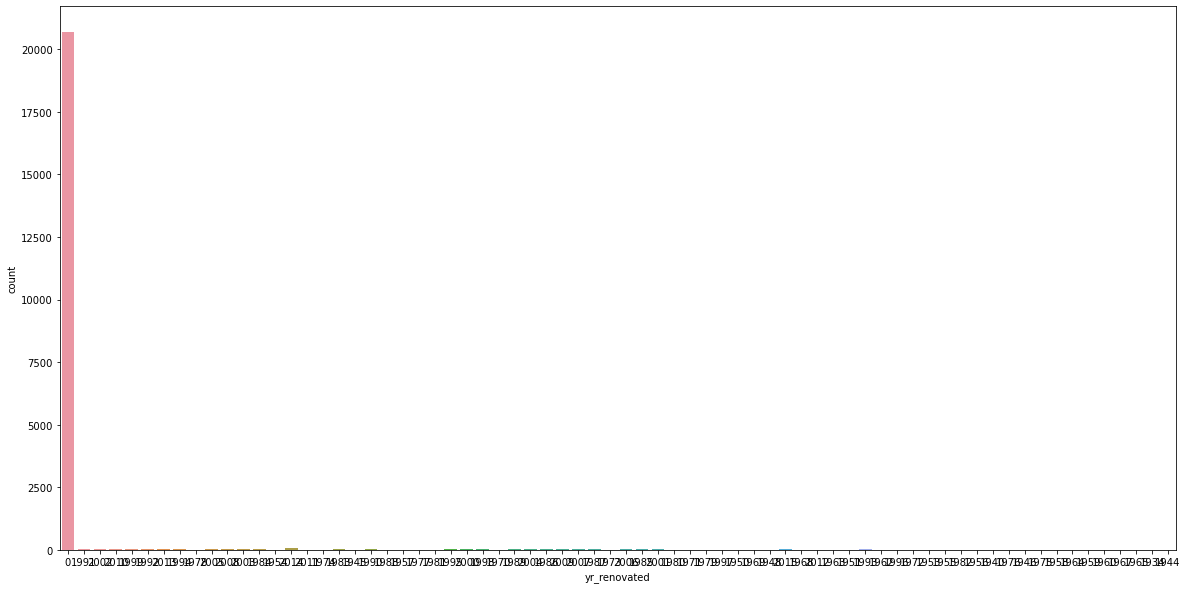

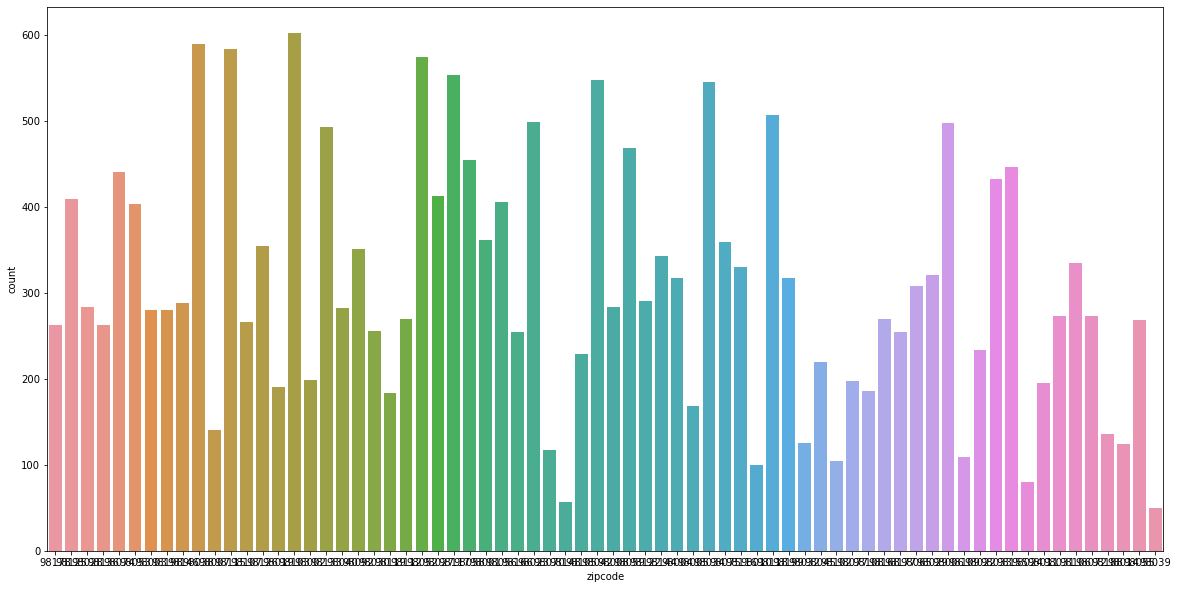

In [9]:
for c in re_df.select_dtypes(object):
    plt.figure(figsize=(20,10))
    sns.countplot(x=re_df[c],data=re_df)
    plt.show()

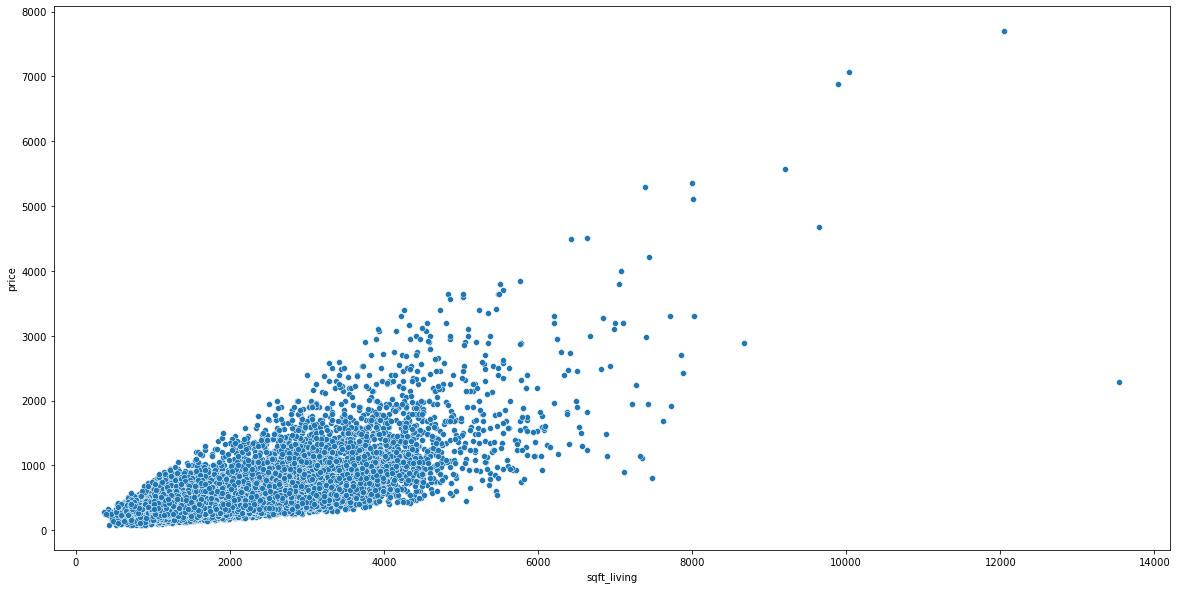

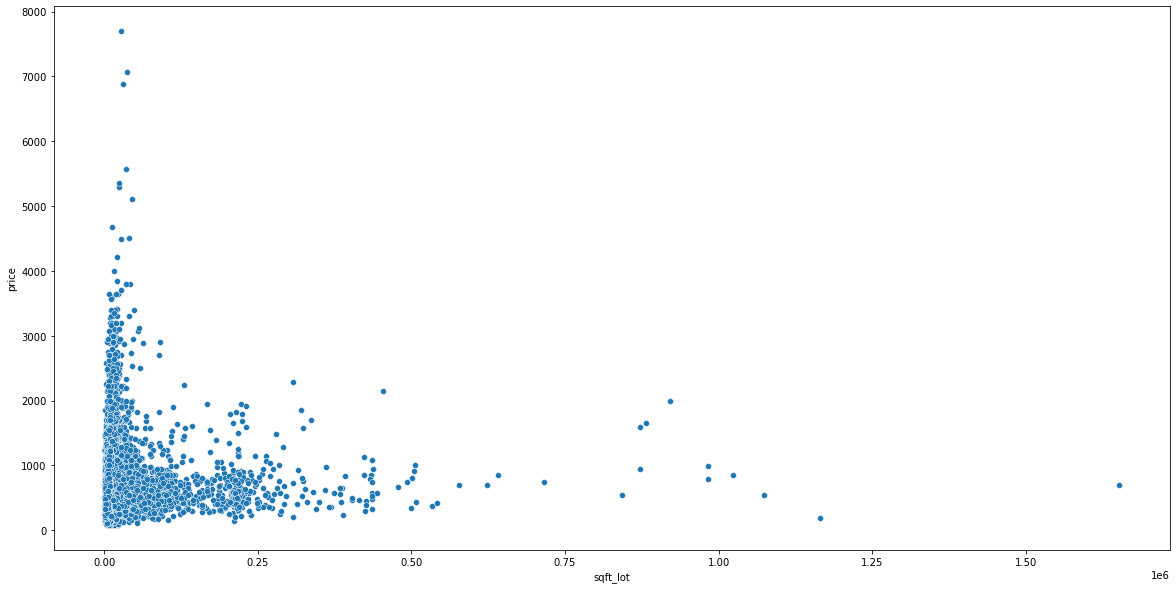

In [10]:
for c in re_df.select_dtypes(int):
    plt.figure(figsize=(20,10))
    sns.scatterplot(y='price',x=re_df[c],data=re_df)
    plt.show()

## removing outliers

<AxesSubplot:xlabel='sqft_living'>

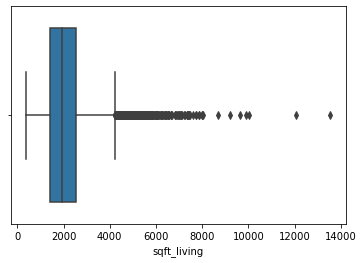

In [11]:
sns.boxplot(re_df.sqft_living)

In [12]:
Q1 = re_df.sqft_living.quantile(0.25)
Q3 = re_df.sqft_living.quantile(0.75) 
IQR = Q3 - Q1

filter = (re_df['sqft_living'] >= Q1 - 1.5 * IQR) & (re_df['sqft_living'] <= Q3 + 1.5 *IQR)
re_df=re_df.loc[filter]

<AxesSubplot:>

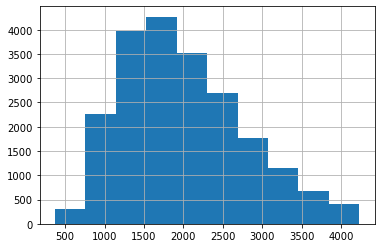

In [13]:
re_df.sqft_living.hist()

<AxesSubplot:xlabel='sqft_lot'>

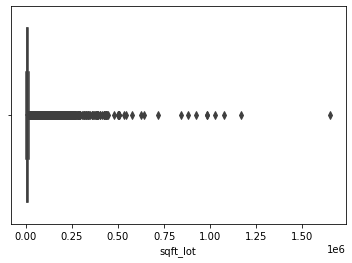

In [14]:
sns.boxplot(re_df.sqft_lot)

In [15]:
Q1 = re_df.sqft_lot.quantile(0.25)
Q3 = re_df.sqft_lot.quantile(0.75)
IQR = Q3 - Q1
filter = (re_df['sqft_lot'] >= Q1 - 1.5 * IQR) & (re_df['sqft_lot'] <= Q3 + 1.5 *IQR)
re_df=re_df.loc[filter]

<AxesSubplot:>

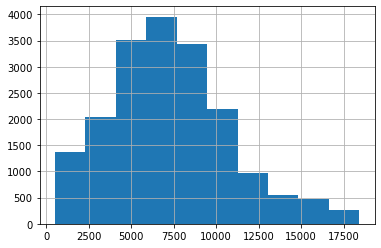

In [16]:
re_df.sqft_lot.hist()

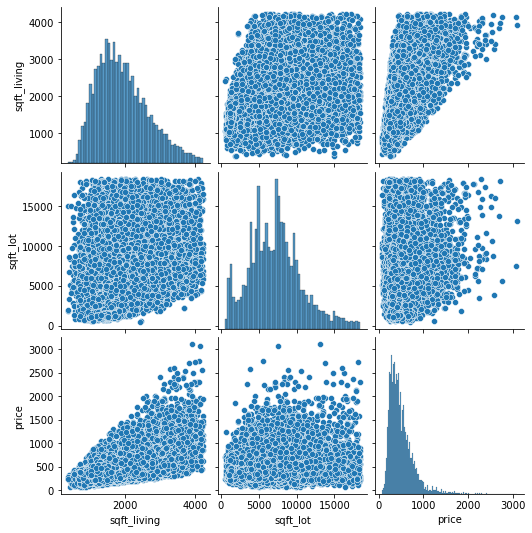

In [17]:
sns.pairplot(re_df)
plt.show()

## Data transformation

In [18]:
sqft_living_transformed,lam=boxcox(re_df['sqft_living'])

<AxesSubplot:ylabel='Count'>

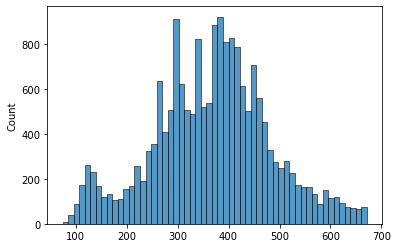

In [19]:
sqft_lot_transformed,lam=boxcox(re_df['sqft_lot'])
sns.histplot(sqft_lot_transformed)

<AxesSubplot:xlabel='sqft_living', ylabel='Density'>

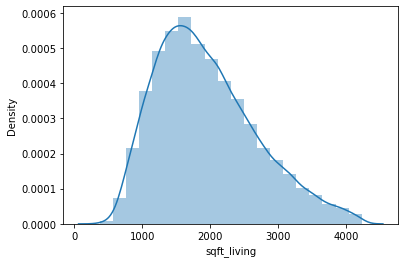

In [20]:
sns.distplot((re_df['sqft_living']), bins=20)

<AxesSubplot:xlabel='sqft_lot', ylabel='Density'>

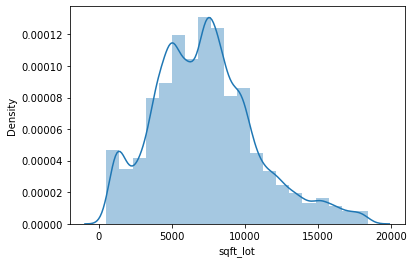

In [21]:
sns.distplot((re_df['sqft_lot']), bins=20)

In [22]:
#checking correlation
numericals_features=re_df._get_numeric_data()
correlations = numericals_features.corr()
correlations

,sqft_living,sqft_lot,price
sqft_living,1.000000,0.231304,0.621203
sqft_lot,0.231304,1.000000,0.054232
price,0.621203,0.054232,1.000000


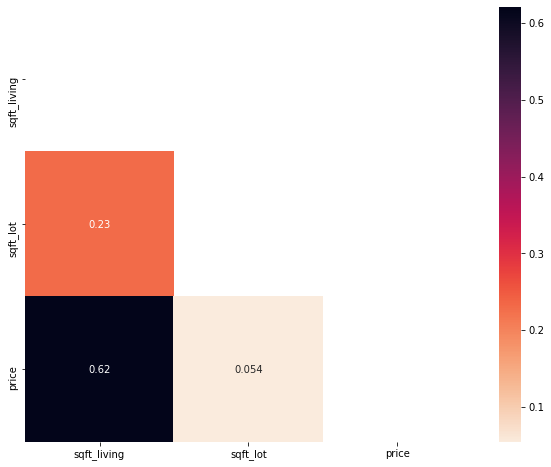

In [23]:
cmap = sns.cm.rocket_r  ## for reversing the colors
mask=np.zeros_like(numericals_features.corr())
mask[np.triu_indices_from(mask)]=True
fig, ax=plt.subplots(figsize=(10, 8))
ax=sns.heatmap(numericals_features.corr(), mask=mask, annot=True,cmap=cmap)
plt.show()

In [24]:
#XY Split
x=re_df.drop('price', axis=1)
y=re_df.price

In [25]:
x

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,yr_renovated,zipcode
0,2014,3,1.0,1180,5650,1.0,0,3,7,1955,0,98178
1,2014,3,2.25,2570,7242,2.0,0,3,7,1951,1991,98125
2,2015,2,1.0,770,10000,1.0,0,3,6,1933,0,98028
3,2014,4,3.0,1960,5000,1.0,0,5,7,1965,0,98136
4,2015,3,2.0,1680,8080,1.0,0,3,8,1987,0,98074
...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2014,3,2.5,1530,1131,3.0,0,3,8,2009,0,98103
21593,2015,4,2.5,2310,5813,2.0,0,3,8,2014,0,98146
21594,2014,2,0.75,1020,1350,2.0,0,3,7,2009,0,98144
21595,2015,3,2.5,1600,2388,2.0,0,3,8,2004,0,98027


In [26]:
numericals_features =x._get_numeric_data()
# numericals =data.select_dtypes(np.number)
numericals_features

,sqft_living,sqft_lot
0,1180,5650
1,2570,7242
2,770,10000
3,1960,5000
4,1680,8080
...,...,...
21592,1530,1131
21593,2310,5813
21594,1020,1350
21595,1600,2388


In [27]:
numericals_features.describe()

,sqft_living,sqft_lot
count,18771.000000,18771.000000
mean,1941.588141,7264.032337
std,740.290170,3502.526355
min,370.000000,520.000000
25%,1380.000000,4838.500000
50%,1830.000000,7200.000000
75%,2400.000000,9282.000000
max,4230.000000,18414.000000


In [28]:
#Get Categorical data

categoricals_features = x.select_dtypes(object)
categoricals_features

,date,bedrooms,bathrooms,floors,waterfront,condition,grade,yr_built,yr_renovated,zipcode
0,2014,3,1.0,1.0,0,3,7,1955,0,98178
1,2014,3,2.25,2.0,0,3,7,1951,1991,98125
2,2015,2,1.0,1.0,0,3,6,1933,0,98028
3,2014,4,3.0,1.0,0,5,7,1965,0,98136
4,2015,3,2.0,1.0,0,3,8,1987,0,98074
...,...,...,...,...,...,...,...,...,...,...
21592,2014,3,2.5,3.0,0,3,8,2009,0,98103
21593,2015,4,2.5,2.0,0,3,8,2014,0,98146
21594,2014,2,0.75,2.0,0,3,7,2009,0,98144
21595,2015,3,2.5,2.0,0,3,8,2004,0,98027


In [29]:
# get dummies pandas
categoricals_features=pd.get_dummies(categoricals_features, drop_first=True)
categoricals_features

,date_2015,bedrooms_10,bedrooms_11,bedrooms_2,bedrooms_3,bedrooms_33,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.75,bathrooms_7.5,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,waterfront_1,condition_2,condition_3,condition_4,condition_5,grade_11,grade_12,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,yr_built_1901,yr_built_1902,yr_built_1903,yr_built_1904,yr_built_1905,yr_built_1906,yr_built_1907,yr_built_1908,yr_built_1909,yr_built_1910,yr_built_1911,yr_built_1912,yr_built_1913,yr_built_1914,yr_built_1915,yr_built_1916,yr_built_1917,yr_built_1918,yr_built_1919,yr_built_1920,yr_built_1921,yr_built_1922,yr_built_1923,yr_built_1924,yr_built_1925,yr_built_1926,yr_built_1927,yr_built_1928,yr_built_1929,yr_built_1930,yr_built_1931,yr_built_1932,yr_built_1933,yr_built_1934,yr_built_1935,yr_built_1936,yr_built_1937,yr_built_1938,yr_built_1939,yr_built_1940,yr_built_1941,yr_built_1942,yr_built_1943,yr_built_1944,yr_built_1945,yr_built_1946,yr_built_1947,yr_built_1948,yr_built_1949,yr_built_1950,yr_built_1951,yr_built_1952,yr_built_1953,yr_built_1954,yr_built_1955,yr_built_1956,yr_built_1957,yr_built_1958,yr_built_1959,yr_built_1960,yr_built_1961,yr_built_1962,yr_built_1963,yr_built_1964,yr_built_1965,yr_built_1966,yr_built_1967,yr_built_1968,yr_built_1969,yr_built_1970,yr_built_1971,yr_built_1972,yr_built_1973,yr_built_1974,yr_built_1975,yr_built_1976,yr_built_1977,yr_built_1978,yr_built_1979,yr_built_1980,yr_built_1981,yr_built_1982,yr_built_1983,yr_built_1984,yr_built_1985,yr_built_1986,yr_built_1987,yr_built_1988,yr_built_1989,yr_built_1990,yr_built_1991,yr_built_1992,yr_built_1993,yr_built_1994,yr_built_1995,yr_built_1996,yr_built_1997,yr_built_1998,yr_built_1999,yr_built_2000,yr_built_2001,yr_built_2002,yr_built_2003,yr_built_2004,yr_built_2005,yr_built_2006,yr_built_2007,yr_built_2008,yr_built_2009,yr_built_2010,yr_built_2011,yr_built_2012,yr_built_2013,yr_built_2014,yr_built_2015,yr_renovated_1934,yr_renovated_1940,yr_renovated_1944,yr_renovated_1945,yr_renovated_1946,yr_renovated_1948,yr_renovated_1950,yr_renovated_1951,yr_renovated_1953,yr_renovated_1955,yr_renovated_1956,yr_renovated_1957,yr_renovated_1958,yr_renovated_1959,yr_renovated_1960,yr_renovated_1962,yr_renovated_1963,yr_renovated_1964,yr_renovated_1965,yr_renovated_1967,yr_renovated_1968,yr_renovated_1969,yr_renovated_1970,yr_renovated_1971,yr_renovated_1972,yr_renovated_1973,yr_renovated_1974,yr_renovated_1975,yr_renovated_1976,yr_renovated_1977,yr_renovated_1978,yr_renovated_1979,yr_renovated_1980,yr_renovated_1981,yr_renovated_1982,yr_renovated_1983,yr_renovated_1984,yr_renovated_1985,yr_renovated_1986,yr_renovated_1987,yr_renovated_1988,yr_renovated_1989,yr_renovated_1990,yr_renovated_1991,yr_renovated_1992,yr_renovated_1993,yr_renovated_1994,yr_renovated_1995,yr_renovated_1996,yr_renovated_1997,yr_renovated_1998,yr_renovated_1999,yr_renovated_2000,yr_renovated_2001,yr_renovated_2002,yr_renovated_2003,yr_renovated_2004,yr_renovated_2005,yr_renovated_2006,yr_renovated_2007,yr_renovated_2008,yr_renovated_2009,yr_renovated_2010,yr_renovated_2011,yr_renovated_2012,yr_renovated_2013,yr_renovated_2014,yr_renovated_2015,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipc

In [30]:
all_features=pd.concat([numericals_features, categoricals_features], axis=1) 
# concat numerical and categorical transformations
all_features

,sqft_living,sqft_lot,date_2015,bedrooms_10,bedrooms_11,bedrooms_2,bedrooms_3,bedrooms_33,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.75,bathrooms_7.5,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,waterfront_1,condition_2,condition_3,condition_4,condition_5,grade_11,grade_12,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,yr_built_1901,yr_built_1902,yr_built_1903,yr_built_1904,yr_built_1905,yr_built_1906,yr_built_1907,yr_built_1908,yr_built_1909,yr_built_1910,yr_built_1911,yr_built_1912,yr_built_1913,yr_built_1914,yr_built_1915,yr_built_1916,yr_built_1917,yr_built_1918,yr_built_1919,yr_built_1920,yr_built_1921,yr_built_1922,yr_built_1923,yr_built_1924,yr_built_1925,yr_built_1926,yr_built_1927,yr_built_1928,yr_built_1929,yr_built_1930,yr_built_1931,yr_built_1932,yr_built_1933,yr_built_1934,yr_built_1935,yr_built_1936,yr_built_1937,yr_built_1938,yr_built_1939,yr_built_1940,yr_built_1941,yr_built_1942,yr_built_1943,yr_built_1944,yr_built_1945,yr_built_1946,yr_built_1947,yr_built_1948,yr_built_1949,yr_built_1950,yr_built_1951,yr_built_1952,yr_built_1953,yr_built_1954,yr_built_1955,yr_built_1956,yr_built_1957,yr_built_1958,yr_built_1959,yr_built_1960,yr_built_1961,yr_built_1962,yr_built_1963,yr_built_1964,yr_built_1965,yr_built_1966,yr_built_1967,yr_built_1968,yr_built_1969,yr_built_1970,yr_built_1971,yr_built_1972,yr_built_1973,yr_built_1974,yr_built_1975,yr_built_1976,yr_built_1977,yr_built_1978,yr_built_1979,yr_built_1980,yr_built_1981,yr_built_1982,yr_built_1983,yr_built_1984,yr_built_1985,yr_built_1986,yr_built_1987,yr_built_1988,yr_built_1989,yr_built_1990,yr_built_1991,yr_built_1992,yr_built_1993,yr_built_1994,yr_built_1995,yr_built_1996,yr_built_1997,yr_built_1998,yr_built_1999,yr_built_2000,yr_built_2001,yr_built_2002,yr_built_2003,yr_built_2004,yr_built_2005,yr_built_2006,yr_built_2007,yr_built_2008,yr_built_2009,yr_built_2010,yr_built_2011,yr_built_2012,yr_built_2013,yr_built_2014,yr_built_2015,yr_renovated_1934,yr_renovated_1940,yr_renovated_1944,yr_renovated_1945,yr_renovated_1946,yr_renovated_1948,yr_renovated_1950,yr_renovated_1951,yr_renovated_1953,yr_renovated_1955,yr_renovated_1956,yr_renovated_1957,yr_renovated_1958,yr_renovated_1959,yr_renovated_1960,yr_renovated_1962,yr_renovated_1963,yr_renovated_1964,yr_renovated_1965,yr_renovated_1967,yr_renovated_1968,yr_renovated_1969,yr_renovated_1970,yr_renovated_1971,yr_renovated_1972,yr_renovated_1973,yr_renovated_1974,yr_renovated_1975,yr_renovated_1976,yr_renovated_1977,yr_renovated_1978,yr_renovated_1979,yr_renovated_1980,yr_renovated_1981,yr_renovated_1982,yr_renovated_1983,yr_renovated_1984,yr_renovated_1985,yr_renovated_1986,yr_renovated_1987,yr_renovated_1988,yr_renovated_1989,yr_renovated_1990,yr_renovated_1991,yr_renovated_1992,yr_renovated_1993,yr_renovated_1994,yr_renovated_1995,yr_renovated_1996,yr_renovated_1997,yr_renovated_1998,yr_renovated_1999,yr_renovated_2000,yr_renovated_2001,yr_renovated_2002,yr_renovated_2003,yr_renovated_2004,yr_renovated_2005,yr_renovated_2006,yr_renovated_2007,yr_renovated_2008,yr_renovated_2009,yr_renovated_2010,yr_renovated_2011,yr_renovated_2012,yr_renovated_2013,yr_renovated_2014,yr_renovated_2015,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_980

In [31]:
#train test split

x_train, x_test, y_train, y_test=train_test_split(all_features, y, test_size=.20, random_state=100)

In [32]:
x_train

,sqft_living,sqft_lot,date_2015,bedrooms_10,bedrooms_11,bedrooms_2,bedrooms_3,bedrooms_33,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.75,bathrooms_7.5,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,waterfront_1,condition_2,condition_3,condition_4,condition_5,grade_11,grade_12,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,yr_built_1901,yr_built_1902,yr_built_1903,yr_built_1904,yr_built_1905,yr_built_1906,yr_built_1907,yr_built_1908,yr_built_1909,yr_built_1910,yr_built_1911,yr_built_1912,yr_built_1913,yr_built_1914,yr_built_1915,yr_built_1916,yr_built_1917,yr_built_1918,yr_built_1919,yr_built_1920,yr_built_1921,yr_built_1922,yr_built_1923,yr_built_1924,yr_built_1925,yr_built_1926,yr_built_1927,yr_built_1928,yr_built_1929,yr_built_1930,yr_built_1931,yr_built_1932,yr_built_1933,yr_built_1934,yr_built_1935,yr_built_1936,yr_built_1937,yr_built_1938,yr_built_1939,yr_built_1940,yr_built_1941,yr_built_1942,yr_built_1943,yr_built_1944,yr_built_1945,yr_built_1946,yr_built_1947,yr_built_1948,yr_built_1949,yr_built_1950,yr_built_1951,yr_built_1952,yr_built_1953,yr_built_1954,yr_built_1955,yr_built_1956,yr_built_1957,yr_built_1958,yr_built_1959,yr_built_1960,yr_built_1961,yr_built_1962,yr_built_1963,yr_built_1964,yr_built_1965,yr_built_1966,yr_built_1967,yr_built_1968,yr_built_1969,yr_built_1970,yr_built_1971,yr_built_1972,yr_built_1973,yr_built_1974,yr_built_1975,yr_built_1976,yr_built_1977,yr_built_1978,yr_built_1979,yr_built_1980,yr_built_1981,yr_built_1982,yr_built_1983,yr_built_1984,yr_built_1985,yr_built_1986,yr_built_1987,yr_built_1988,yr_built_1989,yr_built_1990,yr_built_1991,yr_built_1992,yr_built_1993,yr_built_1994,yr_built_1995,yr_built_1996,yr_built_1997,yr_built_1998,yr_built_1999,yr_built_2000,yr_built_2001,yr_built_2002,yr_built_2003,yr_built_2004,yr_built_2005,yr_built_2006,yr_built_2007,yr_built_2008,yr_built_2009,yr_built_2010,yr_built_2011,yr_built_2012,yr_built_2013,yr_built_2014,yr_built_2015,yr_renovated_1934,yr_renovated_1940,yr_renovated_1944,yr_renovated_1945,yr_renovated_1946,yr_renovated_1948,yr_renovated_1950,yr_renovated_1951,yr_renovated_1953,yr_renovated_1955,yr_renovated_1956,yr_renovated_1957,yr_renovated_1958,yr_renovated_1959,yr_renovated_1960,yr_renovated_1962,yr_renovated_1963,yr_renovated_1964,yr_renovated_1965,yr_renovated_1967,yr_renovated_1968,yr_renovated_1969,yr_renovated_1970,yr_renovated_1971,yr_renovated_1972,yr_renovated_1973,yr_renovated_1974,yr_renovated_1975,yr_renovated_1976,yr_renovated_1977,yr_renovated_1978,yr_renovated_1979,yr_renovated_1980,yr_renovated_1981,yr_renovated_1982,yr_renovated_1983,yr_renovated_1984,yr_renovated_1985,yr_renovated_1986,yr_renovated_1987,yr_renovated_1988,yr_renovated_1989,yr_renovated_1990,yr_renovated_1991,yr_renovated_1992,yr_renovated_1993,yr_renovated_1994,yr_renovated_1995,yr_renovated_1996,yr_renovated_1997,yr_renovated_1998,yr_renovated_1999,yr_renovated_2000,yr_renovated_2001,yr_renovated_2002,yr_renovated_2003,yr_renovated_2004,yr_renovated_2005,yr_renovated_2006,yr_renovated_2007,yr_renovated_2008,yr_renovated_2009,yr_renovated_2010,yr_renovated_2011,yr_renovated_2012,yr_renovated_2013,yr_renovated_2014,yr_renovated_2015,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_980

In [33]:
# Standardize
std_scaler=StandardScaler().fit(x_train) 

x_train_scaled=std_scaler.transform(x_train)

In [34]:
x_test_scaled=std_scaler.transform(x_test)

In [35]:
len(x_train_scaled[1])

306

In [36]:
# Modelling without scaling

x_train_const= sm.add_constant(x_train) # adding a constant

model = sm.OLS(y_train, x_train_const).fit()
predictions_train = model.predict(x_train_const) 

x_test_const = sm.add_constant(x_test) # adding a constant
predictions_test = model.predict(x_test_const) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     237.3
Date:                Wed, 17 Nov 2021   Prob (F-statistic):               0.00
Time:                        16:42:12   Log-Likelihood:                -92177.
No. Observations:               15016   AIC:                         1.850e+05
Df Residuals:                   14710   BIC:                         1.873e+05
Df Model:                         305                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               105.9307     88.47

In [37]:
model.params[list(np.where(model.pvalues < 0.05)[0])].iloc[1:].index.tolist()

['sqft_lot',
 'date_2015',
 'bedrooms_10',
 'bedrooms_3',
 'bedrooms_6',
 'bedrooms_7',
 'bedrooms_8',
 'bathrooms_4.75',
 'floors_2.5',
 'floors_3.0',
 'waterfront_1',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'grade_11',
 'grade_12',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'yr_built_1901',
 'yr_built_1903',
 'yr_built_1908',
 'yr_built_1930',
 'yr_built_1943',
 'yr_built_1951',
 'yr_built_1952',
 'yr_built_1953',
 'yr_built_1954',
 'yr_built_1955',
 'yr_built_1956',
 'yr_built_1957',
 'yr_built_1958',
 'yr_built_1959',
 'yr_built_1960',
 'yr_built_1961',
 'yr_built_1962',
 'yr_built_1963',
 'yr_built_1964',
 'yr_built_1965',
 'yr_built_1966',
 'yr_built_1967',
 'yr_built_1968',
 'yr_built_1969',
 'yr_built_1970',
 'yr_built_1971',
 'yr_built_1972',
 'yr_built_1973',
 'yr_built_1974',
 'yr_built_1975',
 'yr_built_1976',
 'yr_built_1977',
 'yr_built_1978',
 'yr_built_1979',
 'yr_built_1980',
 'yr_built_1982',
 'yr_built_1984',
 'y

In [38]:
significant_features=all_features[model.params[list(np.where(model.pvalues < 0.05)[0])].iloc[1:].index.tolist()]

In [39]:
#with scaling

x_train.columns

Index(['sqft_living', 'sqft_lot', 'date_2015', 'bedrooms_10', 'bedrooms_11',
       'bedrooms_2', 'bedrooms_3', 'bedrooms_33', 'bedrooms_4', 'bedrooms_5',
       ...
       'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166',
       'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188',
       'zipcode_98198', 'zipcode_98199'],
      dtype='object', length=306)

x_train_const_scaled = sm.add_constant(x_train_scaled) # adding a constant

model = sm.OLS(y_train,x_train_const_scaled).fit()
predictions_train = model.predict(x_train_const_scaled) 

y_pred=model.predict(x_test_scaled)

x_test_const_scaled = sm.add_constant(x_test_scaled) # adding a constant
predictions_test = model.predict(x_test_const_scaled) 
print_model = model.summary()
print(print_model)

In [40]:
model=LinearRegression()    # model
model.fit(x_train_scaled, y_train)   # model train

y_pred=model.predict(x_test_scaled)   # model prediction


y_pred_train=model.predict(x_train_scaled)

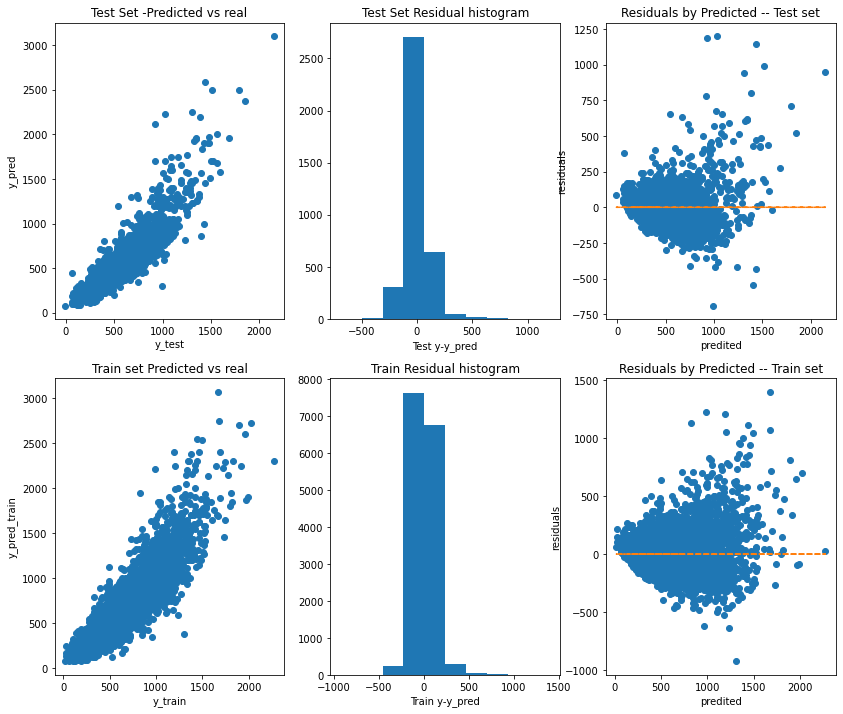

In [41]:
# Make an scatter plot y_pred vs y

fig, ax = plt.subplots(2,3,figsize=(14,12))
ax[0,0].plot(y_pred, y_test, 'o')
ax[0,0].set_xlabel("y_test")
ax[0,0].set_ylabel("y_pred")
ax[0,0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred
ax[0,1].hist(y_test - y_pred)
ax[0,1].set_xlabel("Test y-y_pred")
ax[0,1].set_title("Test Set Residual histogram")

ax[0,2].plot(y_pred,y_test - y_pred,"o")
ax[0,2].set_xlabel("predited")
ax[0,2].set_ylabel("residuals")
ax[0,2].set_title("Residuals by Predicted -- Test set")
ax[0,2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

ax[1,0].plot(y_pred_train, y_train, 'o')
ax[1,0].set_xlabel("y_train")
ax[1,0].set_ylabel("y_pred_train")
ax[1,0].set_title("Train set Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred. 
ax[1,1].hist(y_train - y_pred_train)
ax[1,1].set_xlabel("Train y-y_pred")
ax[1,1].set_title("Train Residual histogram")

ax[1,2].plot(y_pred_train,y_train - y_pred_train,"o")
ax[1,2].set_xlabel("predited")
ax[1,2].set_ylabel("residuals")
ax[1,2].set_title("Residuals by Predicted -- Train set")
ax[1,2].plot(y_pred_train,np.zeros(len(y_pred_train)),linestyle='dashed')

In [42]:
R2_train=r2_score(y_train,y_pred_train)
R2_test=r2_score(y_test,y_pred)

print (R2_train)
print(R2_test)

0.8310734167609968
0.823456352617592


In [43]:
#MSE
train_mse=mse(y_train,y_pred_train)
test_mse=mse(y_test,y_pred)

print ('train MSE: {} -- test MSE: {}'.format(train_mse, test_mse))

train MSE: 12573.272681334502 -- test MSE: 13348.757152195863


In [44]:
#RSME
print ('train RMSE: {} -- test RMSE: {}'.format(train_mse**.5, test_mse**.5))

train RMSE: 112.13060546226664 -- test RMSE: 115.53682162927913


In [45]:
#MAE

train_mae=mae(y_train,y_pred_train)
test_mae=mae(y_test,y_pred)

print ('train MAE: {} -- test MAE: {}'.format(train_mse, test_mse))

train MAE: 12573.272681334502 -- test MAE: 13348.757152195863


In [46]:
Adj_R2_train= 1 - (1-R2_train)*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
Adj_R2_train

0.8275591374441748

In [47]:
Adj_R2_test= 1 - (1-R2_test)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
Adj_R2_test

0.8077886159299421

In [48]:
features_importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': abs(model.coef_)
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)

In [49]:
features_importances.head(10)

,Attribute,Importance
51,grade_7,134.760218
52,grade_8,102.173772
0,sqft_living,99.921545
50,grade_6,88.329527
239,zipcode_98004,73.943587
43,condition_4,68.690603
42,condition_3,62.849231
284,zipcode_98112,60.425115
278,zipcode_98103,60.311936
285,zipcode_98115,56.001899


In [50]:
#Lasso modelling
lasso_model = Lasso().fit(x_train,y_train)
lasso_model.intercept_

279.6015996772984

In [51]:
lasso_model.predict(x_train)

array([660.81743758, 443.98570765, 232.26229649, ..., 229.11751631,
       322.38692421, 316.07886684])

In [54]:
y_pred = lasso_model.predict(x_test)
np.sqrt(mean_squared_error(y_test,y_pred))

142.0565621618632

In [55]:
r2_score(y_test, y_pred)

0.7331090403343612